In [3]:
from pandas import Series
import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression


from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve

In [4]:
data = pd.read_csv('./Project_4_data/train.csv')

### Задание 1
Сколько записей содержит набор данных для моделирования?

In [5]:
data.shape[0]

73799

 **Посмотрим на данные:**
 
 |         |                     |
 |---------|---------------------|
 |client_id|идентификатор клиента|
 |education	|уровень образования|
 |sex	|пол заёмщика|
 |age	|возраст заёмщика|
 |car|	флаг наличия автомобиля|
 |car_type|	флаг автомобиля-иномарки|
 |decline_app_cnt|	количество отказанных прошлых заявок|
 |good_work|	флаг наличия «хорошей» работы|
 |bki_request_cnt|	количество запросов в БКИ|
 |home_address|	категоризатор домашнего адреса|
 |work_address|	категоризатор рабочего адреса|
 |income|	доход заёмщика|
 foreign_passport|	наличие загранпаспорта|
 |default|	наличие дефолта|

In [6]:
# удалим client_id идентификатор клиента
data.drop(columns='client_id',inplace=True)

### Задание 2
Постройте диаграмму для переменной `default`. Каких клиентов у банка больше?
- совершивших дефолт
- без дефолта

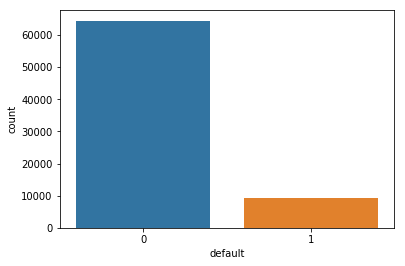

In [7]:
sns.countplot(x="default", data=data);

Посмотрим на тип данных и наличие пропусков:

In [8]:
data.info(verbose=False); print()

for col in data.columns: print('{:20} {}'.format(col, type(data.loc[0][col])))

data.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Columns: 13 entries, education to default
dtypes: int64(8), object(5)
memory usage: 7.3+ MB

education            <class 'str'>
sex                  <class 'str'>
age                  <class 'numpy.int64'>
car                  <class 'str'>
car_type             <class 'str'>
decline_app_cnt      <class 'numpy.int64'>
good_work            <class 'numpy.int64'>
bki_request_cnt      <class 'numpy.int64'>
home_address         <class 'numpy.int64'>
work_address         <class 'numpy.int64'>
income               <class 'numpy.int64'>
foreign_passport     <class 'str'>
default              <class 'numpy.int64'>


education           307
sex                   0
age                   0
car                   0
car_type              0
decline_app_cnt       0
good_work             0
bki_request_cnt       0
home_address          0
work_address          0
income                0
foreign_passport      0
default               0
dtype: int64

В данных о клиентах присутствуют переменные всех типов, не все имеют числовую запись, а также есть пропущенные значения. Значит, нам необходима предварительная очистка данных.

Как мы видим, пропуски встречаются только в информации об образовании клиентов. Посмотрим на признак ближе:

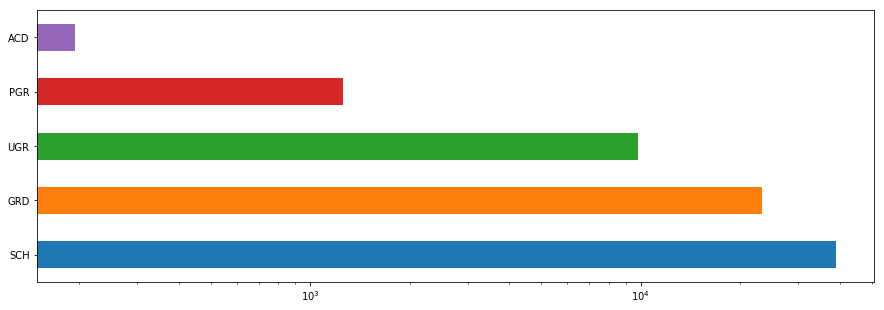

In [9]:
plt.figure(    figsize=(15,5))
data.education.value_counts().plot.barh()
plt.xscale("log")

### ЗАДАНИЕ

А теперь самостоятельно заполните пропуски в поле 'education' любыми известными вам методами.

In [10]:
# заполним пропуски 
data.education.fillna('NAN_EDU', inplace=True)

Полученные признаки сгруппируем в три категории по типу их обработки (категориальные, бинарные и числовые) для дальнейшего удобного анализа.

In [11]:
data.nunique().sort_values(ascending=False)

income              966
age                  52
bki_request_cnt      38
decline_app_cnt      21
education             6
work_address          3
home_address          3
default               2
foreign_passport      2
good_work             2
car_type              2
car                   2
sex                   2
dtype: int64

In [12]:
num_uniq = data.drop(columns='default').nunique()

bin_cols = data.drop(columns='default').columns[num_uniq==2]
cat_cols = data.drop(columns='default').columns[(num_uniq>2) & (num_uniq<7)] 
num_cols = data.drop(columns='default').columns[num_uniq>6]

Посмотрим на распределение числовых данных:

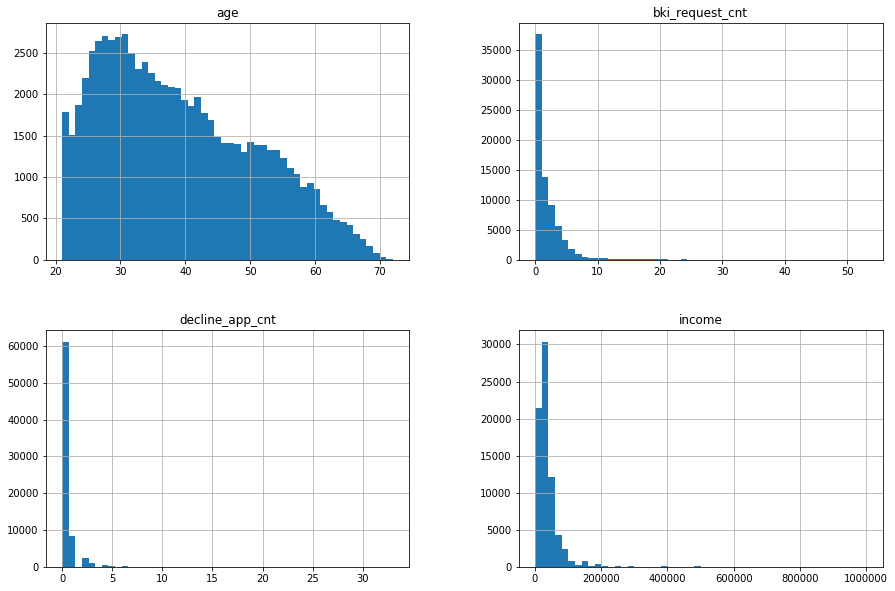

In [13]:
data[num_cols].hist(figsize=(15,10),bins = 50);

Построим графики распределения логарифмированных переменных.

C:\Users\Samsung\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


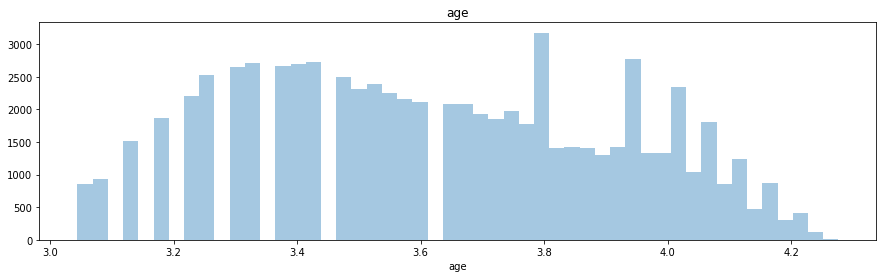

C:\Users\Samsung\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


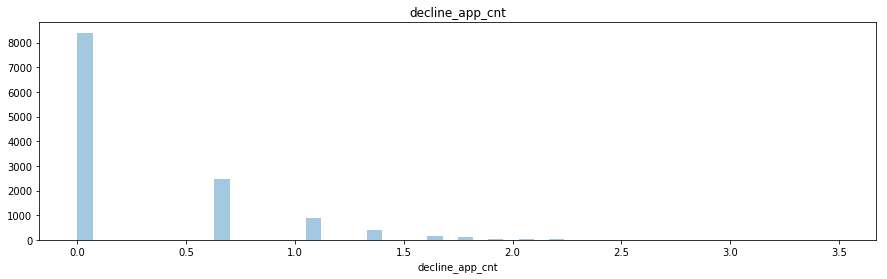

C:\Users\Samsung\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


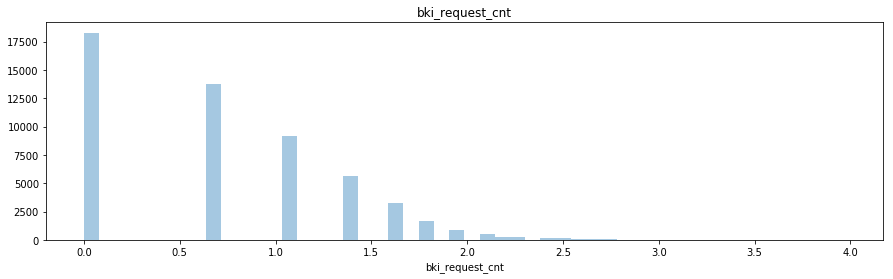

C:\Users\Samsung\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


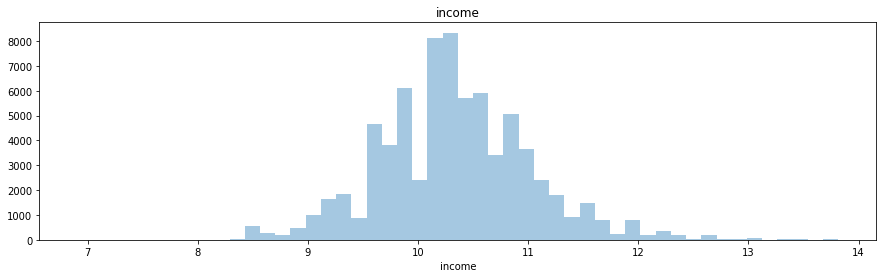

In [14]:
for i in num_cols:
    plt.figure(figsize=(15,4))
    sns.distplot(np.log(data[i][data[i] > 0].dropna()), kde = False, rug=False)
    plt.title(i)
    plt.show()

### Задание 1
Постройте boxplot’ы для численных переменных и ответьте на следующие вопросы:

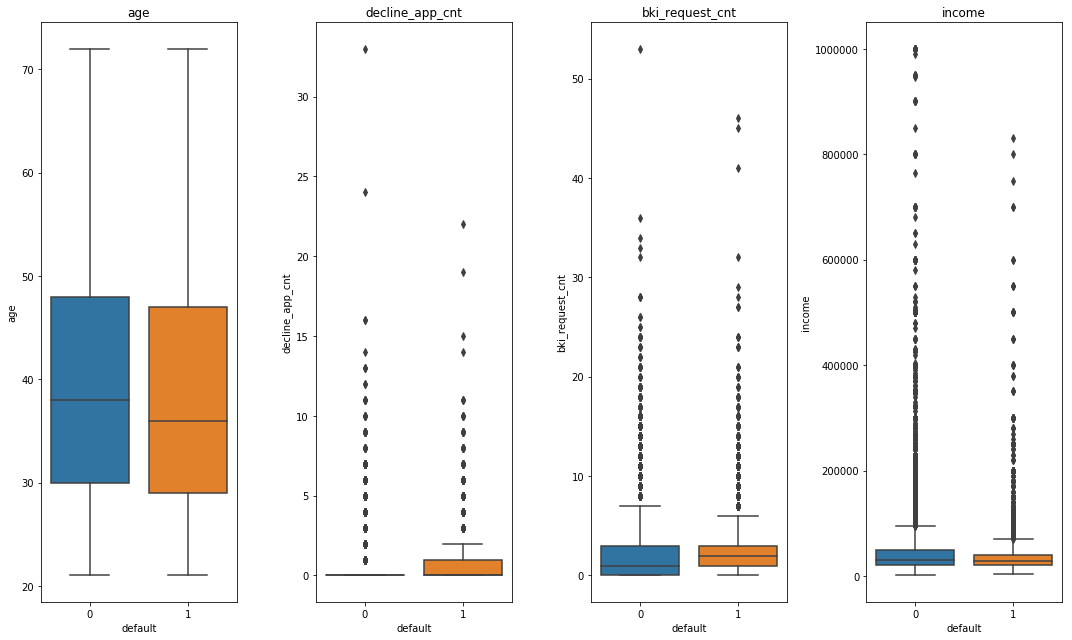

In [15]:
plt.figure(figsize=(15,9))

for i, column in enumerate(num_cols):
    plt.subplot(1, 4, i+1)
    sns.boxplot(x='default',y=data[column],data=data)
    plt.title(column)

plt.tight_layout()

Оценим корреляцию Пирсона для непрерывных переменных по формуле:

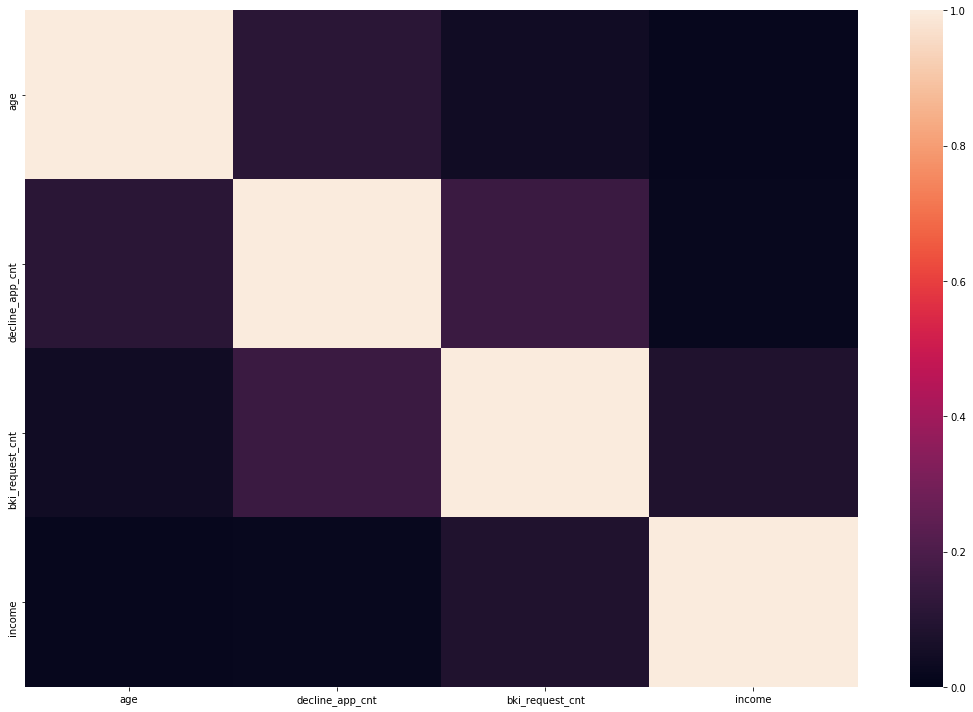

In [16]:
plt.figure(figsize=(15,10))
sns.heatmap(data[num_cols].corr().abs(), vmin=0, vmax=1,)
plt.tight_layout()
# , xticklabels=True, yticklabels=True

Для оценки значимости числовых переменных будем использовать функцию `f_classif` из библиотеки sklearn. 

Возможности модуля `sklearn.feature_selection` могут быть использованы не только для выбора важных признаков, но и для уменьшения размерности, улучшения предсказательной силы моделей, либо для повышения их производительности на очень многомерных наборах данных.

В основе метода оценки значимости переменных лежит однофакторный дисперсионный анализ (ANOVA). Основу процедуры составляет обобщение результатов двух выборочных t-тестов для независимых выборок (2-sample t). 

В качестве меры значимости мы будем использовать значение f-статистики. Чем значение статистики выше, тем меньше вероятность того, что средние значения не отличаются, и тем важнее данный признак для нашей линейной модели.

In [17]:
imp_num = pd.Series(f_classif(data[num_cols], data['default'])[0], index = num_cols)

In [18]:
imp_num.sort_values(inplace = True)

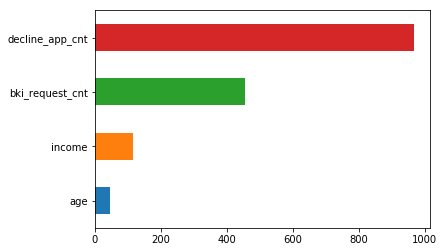

In [19]:
imp_num.plot(kind = 'barh')

## Категориальные переменные
Самый простой способ — отобразить каждое значение категории в уникальное число. Например, в поле `sex` значение `sex = female` преобразовать в $0$, а `sex = male` — в $1$. Эту простую операцию приходится делать достаточно часто, поэтому в модуле `sklearn.preprocessing` именно для этой задачи реализован класс `LabelEncoder`.

Метод `fit` этого класса находит все уникальные значения и строит таблицу для соответствия каждой категории некоторому числу, а метод `transform` непосредственно преобразует значения в числа. После `fit` у `label_encoder` будет доступно поле `classes_`, содержащее все уникальные значения. Можно их пронумеровать и убедиться, что преобразование выполнено верно.

In [20]:
data = pd.read_csv('./Project_4_data/train.csv')

In [21]:
label_encoder = LabelEncoder()

mapped_sex = pd.Series(label_encoder.fit_transform(data['sex']))
print(dict(enumerate(label_encoder.classes_)))

{0: 'F', 1: 'M'}


Сработало! Теперь всегда можно обратиться к `classes_ `, если забыли, что закодировали. Применим `LabelEncoder` ко всему набору бинарных переменных.

In [22]:
# Для бинарных признаков мы будем использовать LabelEncoder

label_encoder = LabelEncoder()

for column in bin_cols:
    data[column] = label_encoder.fit_transform(data[column])
    
# убедимся в преобразовании    
data.head(7)

,client_id,education,sex,age,car,car_type,decline_app_cnt,good_work,bki_request_cnt,home_address,work_address,income,foreign_passport,default
0,25905,SCH,1,62,1,1,0,0,1,1,2,18000,0,0
1,63161,SCH,0,59,0,0,0,0,3,2,3,19000,0,0
2,25887,SCH,1,25,1,0,2,0,1,1,2,30000,1,0
3,16222,SCH,0,53,0,0,0,0,2,2,3,10000,0,0
4,101655,GRD,1,48,0,0,0,1,1,2,3,30000,1,0
5,41415,SCH,1,27,1,0,0,1,0,1,1,15000,0,0
6,28436,SCH,1,39,0,0,0,0,0,1,2,28000,0,0


## ЗНАЧИМОСТЬ КАТЕГОРИАЛЬНЫХ ПРИЗНАКОВ
Для оценки значимости категориальных и бинарных переменных будем использовать функцию `mutual_info_classif` из библиотеки `sklearn`. Данная функция опирается на непараметрические методы, основанные на оценке энтропии в группах категориальных переменных.

In [23]:
data.education.fillna('NAN_EDU',inplace=True)

data.education = label_encoder.fit_transform(data.education)

C:\Users\Samsung\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:605: RuntimeWarning: invalid value encountered in log
  log_outer = -np.log(outer) + log(pi.sum()) + log(pj.sum())


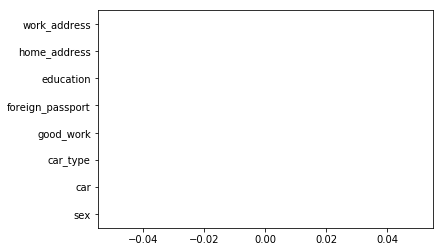

In [25]:
imp_cat = pd.Series(mutual_info_classif(data[bin_cols.append(cat_cols)], data['default'],
                                     discrete_features =True), index = bin_cols.append(cat_cols))
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

In [26]:
imp_cat

sex                NaN
car                NaN
car_type           NaN
good_work          NaN
foreign_passport   NaN
education          NaN
home_address       NaN
work_address       NaN
dtype: float64

In [31]:
data[bin_cols.append(cat_cols)].apply(lambda x: list(x.unique()))

sex                             [1, 0]
car                             [1, 0]
car_type                        [1, 0]
good_work                       [0, 1]
foreign_passport                [0, 1]
education           [4, 1, 5, 3, 0, 2]
home_address                 [1, 2, 3]
work_address                 [2, 3, 1]
dtype: object